
# **Include any disclaimers about the use of AI and cite the parts of the code that AI have been used for.**

In [2]:
import sys
if not sys.version.startswith("3.12"):
    raise RuntimeError("This notebook requires Python 3.12")

#%pip install numpy pandas matplotlib seaborn scikit-learn torch platform psutil getpass

# Hardware and user spercifications

import platform
import psutil
import getpass

# --- Setup: Imports ---
import os, seaborn, sklearn, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle
from sklearn.datasets import load_breast_cancer

#CODE HERE (optional): import any module needed from sklearn package

def print_system_info():
    print("="*60)
    print("SYSTEM INFORMATION")
    print("="*60)

    # OS and hardware
    print(f"Operating System : {platform.system()} {platform.release()}")
    print(f"Processor        : {platform.processor()}")
    print(f"CPU Cores        : {psutil.cpu_count(logical=True)}")
    print(f"RAM              : {round(psutil.virtual_memory().total / (1024**3), 2)} GB")

    # User
    print(f"PC Username      : {getpass.getuser()}")

    # Python and environment
    print(f"Python Version   : {platform.python_version()}")
    print(f"Working Dir      : {os.getcwd()}")

    # GPU (if PyTorch is installed)
    if torch.cuda.is_available():
        print(f"GPU Device       : {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version     : {torch.version.cuda}")
    else:
        print("GPU Device       : None (CPU mode)")

    print("="*60)
    print()

print_system_info()

# Set a random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

SYSTEM INFORMATION
Operating System : Windows 11
Processor        : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU Cores        : 8
RAM              : 31.82 GB
PC Username      : Mahad
Python Version   : 3.12.0
Working Dir      : c:\Users\Mahad\github\4AL3\assignments\A3
GPU Device       : NVIDIA GeForce RTX 4070 SUPER
CUDA Version     : 11.8



Here, we load, split, scale the data. Then we convert them to PyTorch Tensors.

In [4]:
# --- Data Loading and Preprocessing ---

# CODE HERE: Load the dataset
breast_cancer_data = load_breast_cancer()
X = breast_cancer_data.data
y = breast_cancer_data.target

# CODE HERE: Split the data (80% train, 20% validation). Set random_state=random_seed.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=random_seed
)

# CODE HERE: Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# CODE HERE: Convert to PyTorch Tensors

X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val   = y_val.astype(np.float32)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

print(f"Training features shape: {X_train_t.shape}")
print(f"Training labels shape: {y_train_t.shape}")
print(f"Validation features shape: {X_val_t.shape}")
print(f"Validation labels shape: {y_val_t.shape}")


Training features shape: torch.Size([455, 30])
Training labels shape: torch.Size([455, 1])
Validation features shape: torch.Size([114, 30])
Validation labels shape: torch.Size([114, 1])


Next, we define the Neural Network (NN).

In [31]:
# --- Model Definition ---

# CODE HERE: define the asked NN here
class FeedForwardNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)
        return x

input_features = X_train_t.shape[1]
print(f"Model will accept {input_features} input features.")
print("--- 3. Model Class Defined ---")

Model will accept 30 input features.
--- 3. Model Class Defined ---


Part 1:

In [ ]:
def calculate_full_loss(model, criterion, X, y):
    """Helper function to calculate loss over an entire dataset."""
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        outputs = model(X)
        loss = criterion(outputs, y)
    model.train() # Set model back to train mode
    return loss.item()

def stochastic_gradient_descent(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                                max_iterations, check_every, patience, threshold):

    #CODE HERE: fill function. Use calculate_full_loss function for loss.

    n = X_train.shape[0]

    iterations, train_losses, val_losses = [], [], []
    stochastic_losses = []
    best_val = float('inf')
    best_model_state = None
    no_improve = 0
    stop_iteration = max_iterations  

    model.train()
    for it in range(1, max_iterations + 1):
        i = torch.randint(0, n, (1,)).item()
        xb, yb = X_train[i:i+1], y_train[i:i+1]

        optimizer.zero_grad()
        logits = model(xb)                
        loss = criterion(logits, yb)       
        loss.backward()
        optimizer.step()

        stochastic_losses.append(loss.item())

        if it % check_every == 0 or it == 1:
            tr_loss = calculate_full_loss(model, criterion, X_train, y_train)
            va_loss = calculate_full_loss(model, criterion, X_val,   y_val)

            iterations.append(it)
            train_losses.append(tr_loss)
            val_losses.append(va_loss)

            if (best_val - va_loss) >= threshold:
                best_val = va_loss
                # AI GENERATED CODE BLOCK START
                best_model_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
                # AI GENERATED CODE BLOCK END
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    stop_iteration = it
                    break  # stop as soon as patience is exceeded
    

    return train_losses, val_losses, iterations, stop_iteration, best_model_state, stochastic_losses



Training and plot:

Plotting Part 1 results...


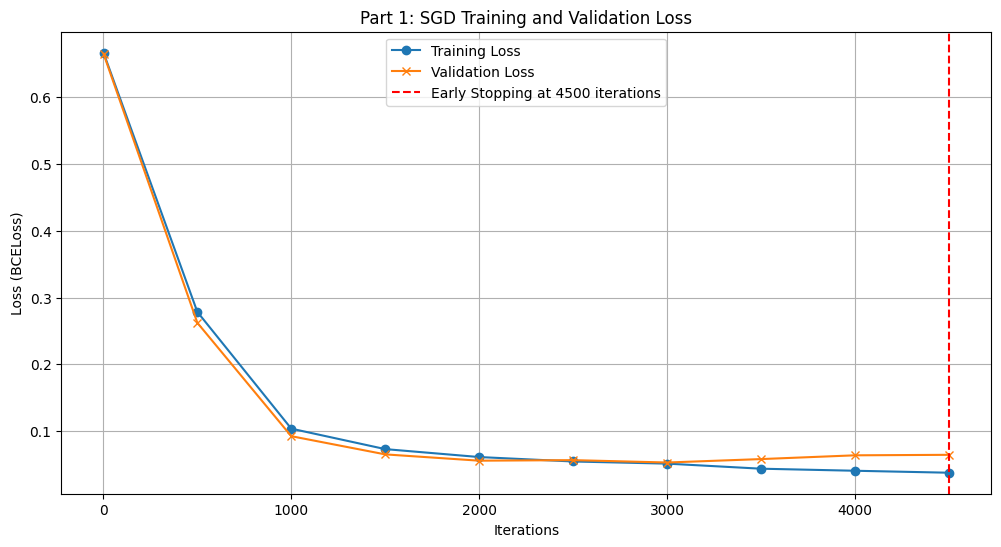


Accuracy of Early-Stopped Model on Validation Set: 99.12%


In [ ]:
# --- Hyperparameters for Part 1 ---
LEARNING_RATE = 1e-2
MAX_ITERATIONS = 5000
CHECK_EVERY = MAX_ITERATIONS // 10
PATIENCE = 3
THRESHOLD = 1e-4

# --- Model Initialization ---

model_sgd = FeedForwardNet(input_size=input_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_sgd.parameters(), lr=LEARNING_RATE)

# --- Run Training ---

train_losses_sgd, val_losses_sgd, iterations_sgd, stop_iter, best_state, stochastic_losses = stochastic_gradient_descent(
    model_sgd, criterion, optimizer,
    X_train_t, y_train_t, X_val_t, y_val_t,
    MAX_ITERATIONS, CHECK_EVERY, PATIENCE, THRESHOLD
)

if best_state is not None:
    model_sgd.load_state_dict(best_state)

# --- Plotting Results ---
print("Plotting Part 1 results...")
plt.figure(figsize=(12, 6))
plt.plot(iterations_sgd, train_losses_sgd, label='Training Loss', marker='o')
plt.plot(iterations_sgd, val_losses_sgd, label='Validation Loss', marker='x')
plt.axvline(x=stop_iter, color='red', linestyle='--',
            label=f'Early Stopping at {stop_iter} iterations')
plt.title('Part 1: SGD Training and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (BCELoss)')
plt.legend()
plt.grid(True)
plt.show()

# --- Final Accuracy ---

#CODE HERE

with torch.no_grad():

    probs = torch.sigmoid(model_sgd(X_val_t)).numpy().ravel() 
    preds = (probs >= 0.5).astype(int)
    accuracy = accuracy_score(y_val, preds)

    print(f"\nAccuracy of Early-Stopped Model on Validation Set: {accuracy * 100:.2f}%")


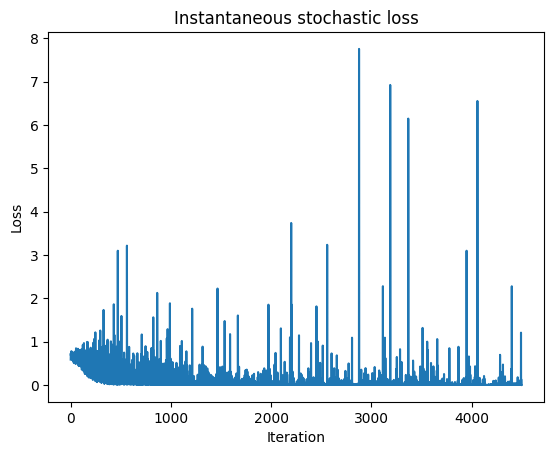

In [34]:
plt.plot(stochastic_losses)
plt.title("Instantaneous stochastic loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Part 2:

In [35]:
def train_with_minibatch(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                         num_iterations, batch_size, check_every):

    n = X_train.shape[0]
    iterations, train_losses, val_losses = [], [], []
    batch_losses = []
    it = 0
    model.train()

    while it < num_iterations:
        # create a random minibatch
        perm = torch.randperm(n)
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            xb, yb = X_train[idx], y_train[idx]

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)   
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            it += 1

            if it % check_every == 0 or it == 1:
                tr = calculate_full_loss(model, criterion, X_train, y_train)
                va = calculate_full_loss(model, criterion, X_val,   y_val)
                iterations.append(it)
                train_losses.append(tr)
                val_losses.append(va)
            if it >= num_iterations:
                break

    return train_losses, val_losses, iterations, model, batch_losses # Return the final model


Training and plot:

Plotting Part 2 comparison...


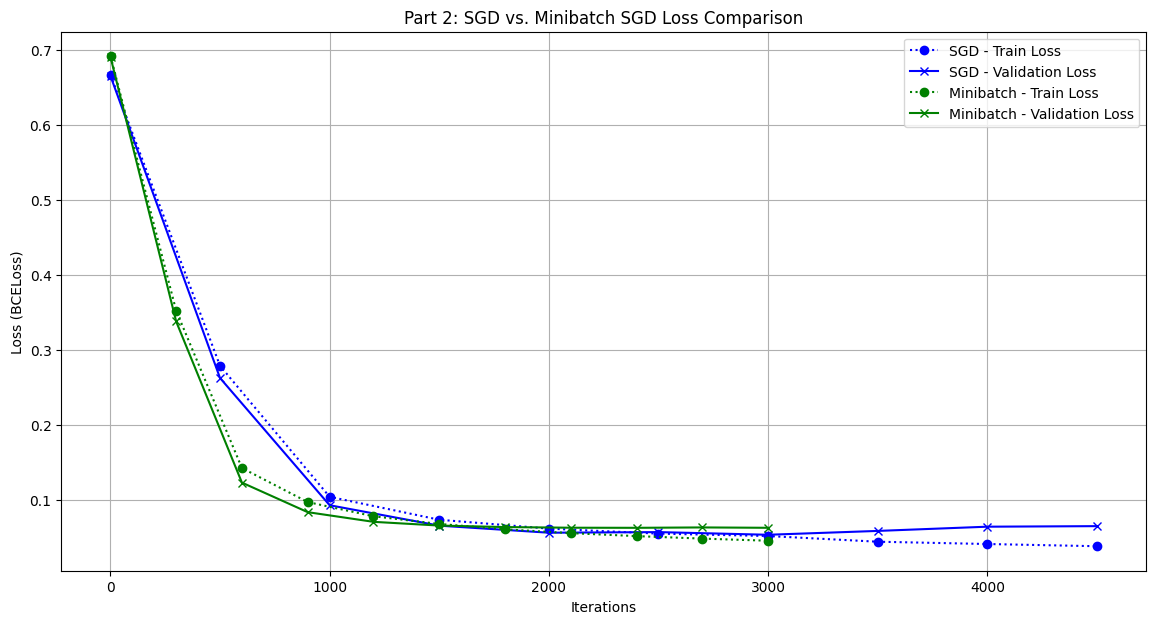

In [36]:
# --- Hyperparameters for Part 2 ---
LEARNING_RATE_MB = 1e-2
NUM_ITERATIONS_MB = 3000
BATCH_SIZE = 64
CHECK_EVERY_MB = NUM_ITERATIONS_MB // 10

# --- Model Initialization ---

model_mb = FeedForwardNet(input_size=input_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model_mb.parameters(), lr=LEARNING_RATE_MB)

# --- Run Minibatch Training ---

# --- Run Minibatch Training ---
train_losses_mb, val_losses_mb, iterations_mb, model_mb, batch_losses = train_with_minibatch(
    model_mb, criterion, optimizer,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS_MB, BATCH_SIZE, CHECK_EVERY_MB
)


# --- Plotting Comparison ---
print("Plotting Part 2 comparison...")
plt.figure(figsize=(14, 7))

# SGD (Part 1)
plt.plot(iterations_sgd, train_losses_sgd, label='SGD - Train Loss', linestyle=':', color='blue', marker='o')
plt.plot(iterations_sgd, val_losses_sgd, label='SGD - Validation Loss', linestyle='-', color='blue', marker='x')

# Minibatch (Part 2)
plt.plot(iterations_mb, train_losses_mb, label='Minibatch - Train Loss', linestyle=':', color='green', marker='o')
plt.plot(iterations_mb, val_losses_mb, label='Minibatch - Validation Loss', linestyle='-', color='green', marker='x')

plt.title('Part 2: SGD vs. Minibatch SGD Loss Comparison')
plt.xlabel('Iterations')
plt.ylabel('Loss (BCELoss)')
plt.legend()
plt.grid(True)
plt.show()



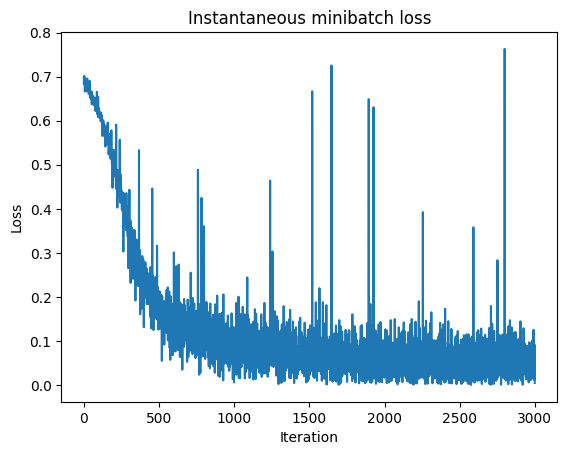

In [37]:
plt.plot(batch_losses)
plt.title("Instantaneous minibatch loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Performance evaluation:

In [ ]:
# --- Performance Metrics Comparison ---

def get_metrics(model, X_val, y_val):
    """Helper function to get accuracy, precision, and recall."""
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_val)
        y_pred = (y_pred_prob > 0.5).int().numpy() 
        y_true = y_val.numpy()

        acc = accuracy_score(y_true, y_pred)
        pre = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
    return acc, pre, rec

# Get metrics for Part 1 (Early-Stopped SGD Model)

acc_sgd, pre_sgd, rec_sgd = get_metrics(model_sgd, X_val_t, y_val_t)

# Get metrics for Part 2 (Final Minibatch Model)

acc_mb, pre_mb, rec_mb = get_metrics(model_mb, X_val_t, y_val_t)

# --- Show Results in a Table ---
results = {
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Part 1: Early-Stopped SGD': [f"{acc_sgd:.4f}", f"{pre_sgd:.4f}", f"{rec_sgd:.4f}"],
    'Part 2: Minibatch SGD': [f"{acc_mb:.4f}", f"{pre_mb:.4f}", f"{rec_mb:.4f}"]
}

results_df = pd.DataFrame(results)
print("\n--- Final Performance Metrics on Validation Set ---")

from IPython.display import display
display(results_df)



--- Final Performance Metrics on Validation Set ---


,Metric,Part 1: Early-Stopped SGD,Part 2: Minibatch SGD
0,Accuracy,0.9737,0.9737
1,Precision,0.9857,0.9857
2,Recall,0.9718,0.9718


# EXPLAIN HERE: Based on your experiments, answer the following questions:

1) How does early stopping affect the training and validation loss curves compared to training for all 5000 iterations?

early stopping prevents the model from overfitting. it halts the model right before the model starts to overfit, from the graph we can see the validation loss start to increase where the loss starts to plateau and not decrease anymore. If we were to keep training to 5000 iterations, the training loss would continue to decrease but validation loss can continue to rise and hurt the accuracy of the model.

2) How does minibatch SGD affect the smoothness of loss curves compared to true SGD with batch_size=1?

both SGD and MB get to around the same level of accuracy as shown in the losso curves where they both plateau at around the same loss. Minibatch also is more accuracte in the earlier iterations compared to SGD showing  its faster at converging the data which in turn makes the loss curve more smooth due to the less noise and randomness

***Part 3***

In [39]:
class FeedForwardNetWithDropout(nn.Module):
    """
    TODO: Complete this neural network class to include dropout layers.

    The dropout_rate parameter should control the dropout probability.
    When dropout_rate=0.0, no dropout is applied.
    """
    def __init__(self, input_size, dropout_rate=0.0):
        super(FeedForwardNetWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)
        self.relu = nn.ReLU()

        self.drop = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        """
        TODO: Implement the forward pass.

        Return the final output.
        """

        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.relu(self.fc2(x))
        x = self.drop(x)
        out = self.out(x)

        return out




In [40]:
def calculate_accuracy(model, X, y):
    """
    TODO: Implement accuracy calculation.


    """
    
    model.eval()

    with torch.no_grad():
        # CODE HERE: Get model outputs
        outputs = model(X)
        probs = torch.sigmoid(outputs)
        predictions = (probs >= 0.5).float()
        accuracy = (predictions.eq(y).sum().float() / y.shape[0]).item()
    return accuracy


In [41]:
def train_with_dropout(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                                 num_iterations, batch_size, check_every):
    """
    TODO: Complete this training function to support dropout.

    """
    n = X_train.shape[0]

    iterations, train_losses, val_losses = [], [], []
    train_accs, val_accs = [], []

    it = 0
    model.train()

    while it < num_iterations:

        perm = torch.randperm(n)
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            xb, yb = X_train[idx], y_train[idx]

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            it += 1

            if it % check_every == 0 or it == 1:
                tr_loss = calculate_full_loss(model, criterion, X_train, y_train)
                va_loss = calculate_full_loss(model, criterion, X_val,   y_val)

                tr_acc = calculate_accuracy(model, X_train, y_train)
                va_acc = calculate_accuracy(model, X_val, y_val)

                iterations.append(it)
                train_losses.append(tr_loss)
                val_losses.append(va_loss)
                train_accs.append(tr_acc)
                val_accs.append(va_acc)
            
            if it >= num_iterations: break


    return train_losses, val_losses, train_accs, val_accs, iterations

In [42]:
DROPOUT_RATES = [0, 0.1, 0.3, 0.5]
LEARNING_RATE_DROPOUT = 1e-2
NUM_ITERATIONS_DROPOUT = 3000
BATCH_SIZE_DROPOUT = 32
CHECK_EVERY_DROPOUT = NUM_ITERATIONS_DROPOUT // 10

dropout_results = {}

for dropout_rate in DROPOUT_RATES:
    print(f"\n--- Training with Dropout Rate = {dropout_rate} ---")

    # CODE HERE: Initialize model with current dropout_rate
    model = FeedForwardNetWithDropout(input_size=input_features, dropout_rate=dropout_rate)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE_DROPOUT)


    # Train the model
    train_losses, val_losses, train_accs, val_accs, iterations = train_with_dropout(
        model, criterion, optimizer,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_ITERATIONS_DROPOUT, BATCH_SIZE_DROPOUT, CHECK_EVERY_DROPOUT
    )

    # Store results for later comparison
    dropout_results[dropout_rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'iterations': iterations,
        'model': model
    }

    print(f"Final Training Accuracy: {train_accs[-1]*100:.2f}%")
    print(f"Final Validation Accuracy: {val_accs[-1]*100:.2f}%")



--- Training with Dropout Rate = 0 ---
Final Training Accuracy: 99.12%
Final Validation Accuracy: 98.25%

--- Training with Dropout Rate = 0.1 ---
Final Training Accuracy: 98.90%
Final Validation Accuracy: 98.25%

--- Training with Dropout Rate = 0.3 ---
Final Training Accuracy: 98.90%
Final Validation Accuracy: 98.25%

--- Training with Dropout Rate = 0.5 ---
Final Training Accuracy: 98.68%
Final Validation Accuracy: 95.61%


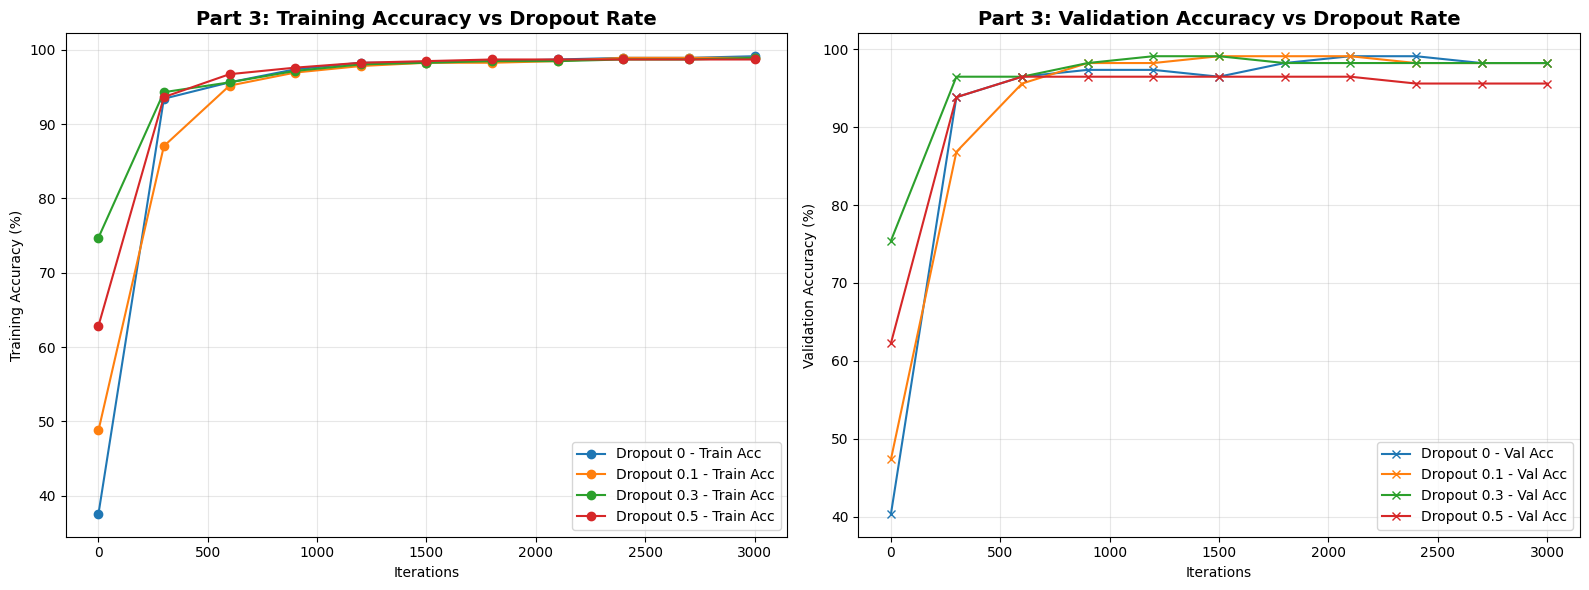

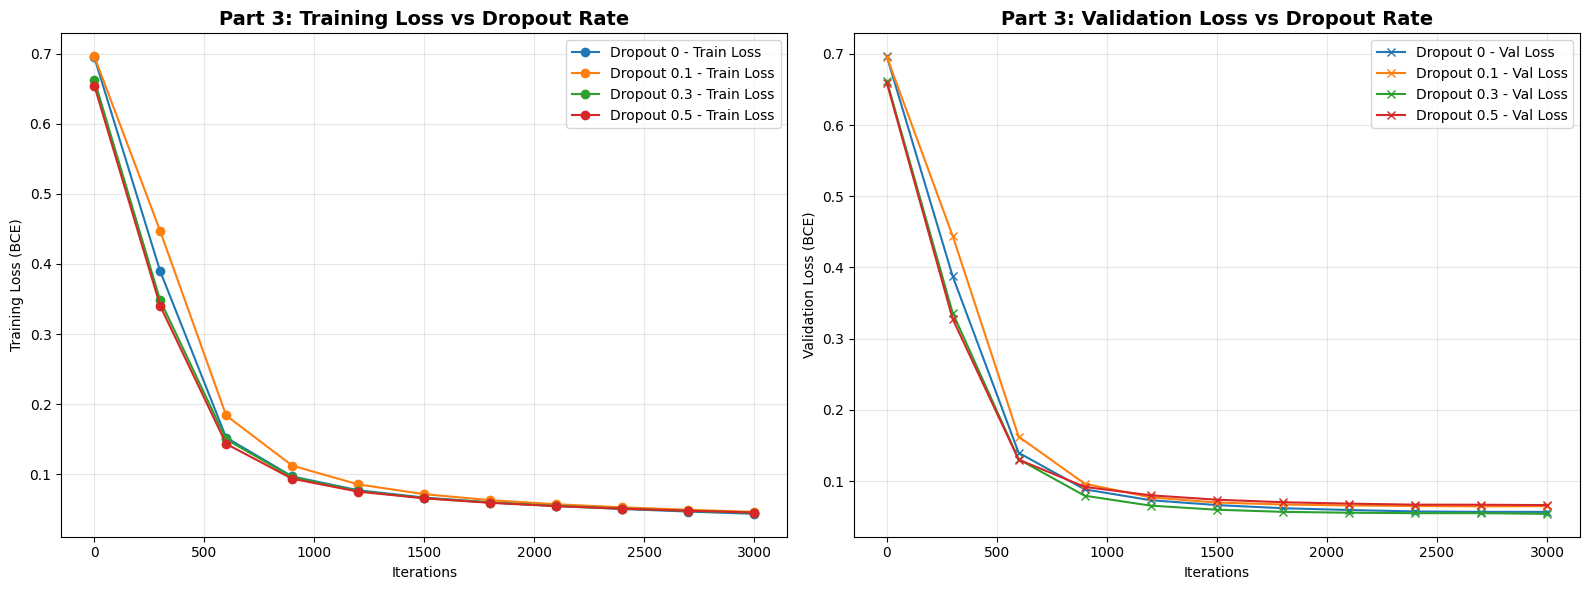

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracies/validations vs dropouts

for rate, results in dropout_results.items():
    axes[0].plot(results['iterations'],
                 [a * 100 for a in results['train_accs']],
                 label=f"Dropout {rate} - Train Acc", marker='o')
    axes[1].plot(results['iterations'],
                 [a * 100 for a in results['val_accs']],
                 label=f"Dropout {rate} - Val Acc", marker='x')

axes[0].set_title('Part 3: Training Accuracy vs Dropout Rate', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Accuracy (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# CODE HERE: inject points in plots

axes[1].set_title('Part 3: Validation Accuracy vs Dropout Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for rate, results in dropout_results.items():
    axes[0].plot(results['iterations'],
                 results['train_losses'],
                 label=f"Dropout {rate} - Train Loss", marker='o')
    axes[1].plot(results['iterations'],
                 results['val_losses'],
                 label=f"Dropout {rate} - Val Loss", marker='x')


axes[0].set_title('Part 3: Training Loss vs Dropout Rate', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Part 3: Validation Loss vs Dropout Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [44]:
# CODE HERE: Create a summary dataframe with the following columns:

dropout_summary = {
    'Dropout Rate': [],
    'Final Train Acc (%)': [],
    'Final Val Acc (%)': [],
    'Final Train Loss': [],
    'Final Val Loss': []
}


for rate, results in dropout_results.items():
    dropout_summary['Dropout Rate'].append(rate)
    dropout_summary['Final Train Acc (%)'].append(results['train_accs'][-1] * 100)
    dropout_summary['Final Val Acc (%)'].append(results['val_accs'][-1] * 100)
    dropout_summary['Final Train Loss'].append(results['train_losses'][-1])
    dropout_summary['Final Val Loss'].append(results['val_losses'][-1])

dropout_df = pd.DataFrame(dropout_summary)
display(dropout_df)



,Dropout Rate,Final Train Acc (%),Final Val Acc (%),Final Train Loss,Final Val Loss
0,0.0,99.120879,98.245615,0.043586,0.056899
1,0.1,98.901099,98.245615,0.046398,0.064935
2,0.3,98.901099,98.245615,0.044996,0.054128
3,0.5,98.681319,95.614034,0.045456,0.066414


#EXPLAIN HERE: Based on your results, answer the following questions:


1. Which dropout rate shows the best generalization (smallest gap between
   training and validation accuracy)?

0.5 and 0.3 dropout rates have the smallest gap between training and validation accuracy, meaning this values generalize the model the best. When we chose dropout rate at 0.5 the validation accuracy drops by alot, this means this model underfits the data.


2. Which dropout rate would you recommend for this dataset and why?

for this dataset I would  recommend a dropout rate of 0.3 . This is because firstly, 0.1 and 0.3 have the smallest gap between training accuracy and val accuracy compared to 0.5 and 0. and between 0.1 and 0.3, the dropoutrate 0.3 has a smaller train loss and val loss compared to 0.1, therefore i would recommend drop out rate of 0.3 to achieve the highest accuracy and lowest loss.

3. What are the trade-offs between low dropout (0.1) and high dropout (0.5)?

low dropout rate -> risk of overfitting

high dropout rate -> leads to underfitting and lower validation accuracy


***Part 4***

In [45]:
def train_with_minibatch_l2(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                            num_iterations, batch_size, check_every):
    """
    #TODO: Implement training with L2 regularization.

    """
    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []

    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    current_idx = 0

    model.train() # set model to training mode
    for i in range(num_iterations + 1):
        if current_idx + batch_size > n_samples:
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy(),
                                            random_state=random_seed + i)
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_idx = 0

        X_batch = X_train_shuffled[current_idx : current_idx + batch_size]
        y_batch = y_train_shuffled[current_idx : current_idx + batch_size]
        current_idx += batch_size

        # L2 penalty is handled by optimizer.weight_decay parameter
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        if i % check_every == 0:
            tr = calculate_full_loss(model, criterion, X_train, y_train)
            va = calculate_full_loss(model, criterion, X_val,   y_val)
            iterations.append(i)
            train_losses.append(tr)
            val_losses.append(va)

    return train_losses, val_losses, iterations


In [46]:
def train_with_minibatch_l1(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                            num_iterations, batch_size, check_every, lambda_l1):
    """
    TODO: Implement training with manual L1 regularization.
    """
    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []

    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    current_idx = 0

    for i in range(num_iterations + 1):
        if current_idx + batch_size > n_samples:
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy(),
                                            random_state=random_seed + i)
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_idx = 0

        X_batch = X_train_shuffled[current_idx : current_idx + batch_size]
        y_batch = y_train_shuffled[current_idx : current_idx + batch_size]
        current_idx += batch_size

        model.train()
        optimizer.zero_grad()

        # CODE HERE: Calculate outputs and BCE loss
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # CODE HERE: Calculate L1 penalty

        l1_penalty = 0
        for p in model.parameters():
            l1_penalty += p.abs().sum()

        # CODE HERE: Calculate total loss
        total_loss = loss + lambda_l1 * l1_penalty

        # TODO: Backpropagate and update weights using total_loss
        total_loss.backward()
        optimizer.step()

        if i % check_every == 0:
            tr = calculate_full_loss(model, criterion, X_train, y_train)
            va = calculate_full_loss(model, criterion, X_val,   y_val)
            iterations.append(i)
            train_losses.append(tr)
            val_losses.append(va)

    return train_losses, val_losses, iterations

In [47]:
LAMBDA_L2_VALUES = [1e-4, 1e-3, 1e-2, 1e-1, 0, 1, 10, 100]
LEARNING_RATE_L2 = 1e-2
NUM_ITERATIONS_L2 = 3000
BATCH_SIZE_L2 = 32
CHECK_EVERY_L2 = NUM_ITERATIONS_L2 // 10

l2_results = {}

for lambda_l2 in LAMBDA_L2_VALUES:
    print(f"\n--- Training with L2 λ = {lambda_l2} ---")

    # CODE HERE: Initialize & train the model (use original FeedForwardNet, no dropout)
    model = FeedForwardNet(input_size=input_features)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE_L2, weight_decay=lambda_l2)

    train_losses, val_losses, iterations = train_with_minibatch_l2(
        model, criterion, optimizer,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_ITERATIONS_L2, BATCH_SIZE_L2, CHECK_EVERY_L2
    )

    # CODE HERE: Calculate final validation accuracy
    final_accuracy = calculate_accuracy(model, X_val_t, y_val_t)

    # Store results
    l2_results[lambda_l2] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'iterations': iterations,
        'final_accuracy': final_accuracy,
        'model': model
    }

    print(f"Final Validation Accuracy: {final_accuracy*100:.2f}%")


--- Training with L2 λ = 0.0001 ---
Final Validation Accuracy: 97.37%

--- Training with L2 λ = 0.001 ---
Final Validation Accuracy: 98.25%

--- Training with L2 λ = 0.01 ---
Final Validation Accuracy: 98.25%

--- Training with L2 λ = 0.1 ---
Final Validation Accuracy: 99.12%

--- Training with L2 λ = 0 ---
Final Validation Accuracy: 99.12%

--- Training with L2 λ = 1 ---
Final Validation Accuracy: 62.28%

--- Training with L2 λ = 10 ---
Final Validation Accuracy: 62.28%

--- Training with L2 λ = 100 ---
Final Validation Accuracy: 62.28%


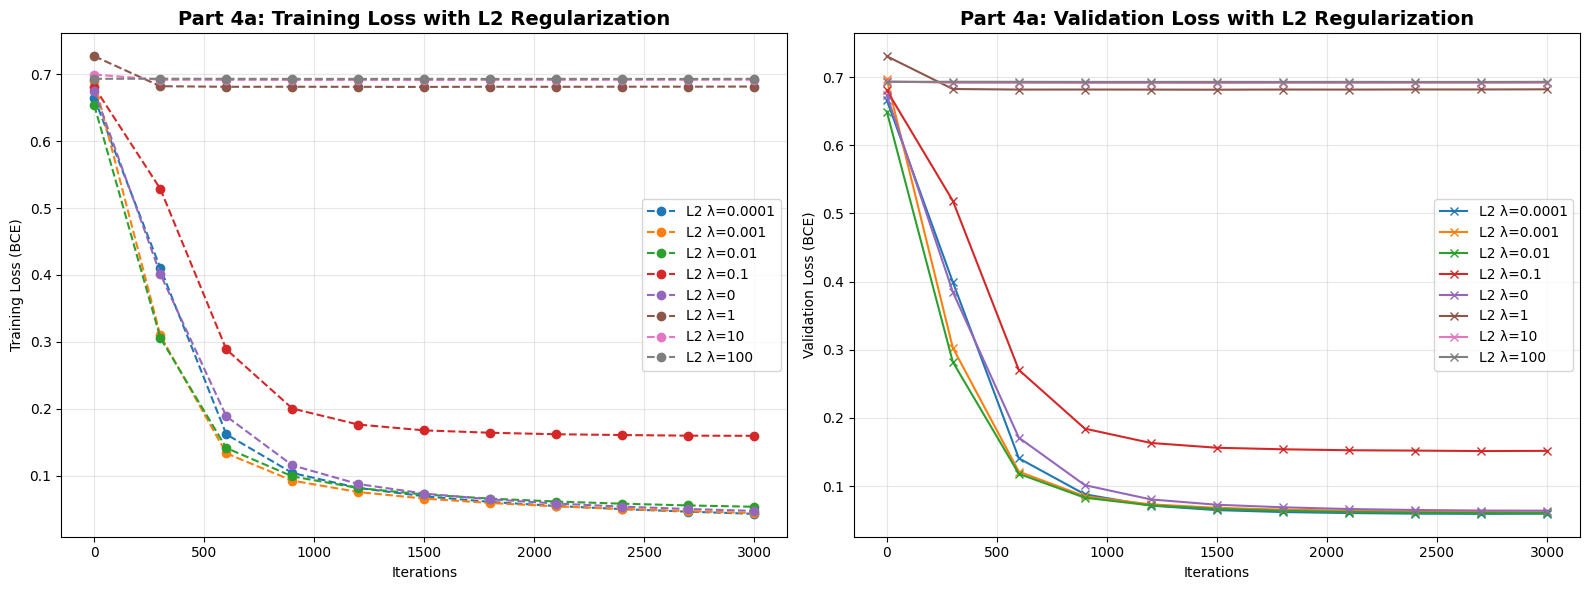

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# TODO: Plot training/validation loss for all L2 values
# CODE HERE: Inject points to plots
# training losses
for lambda_l2, results in l2_results.items():
    axes[0].plot(
        results['iterations'],
        results['train_losses'],
        label=f"L2 λ={lambda_l2}",
        marker='o',
        linestyle='--'
    )


axes[0].set_title('Part 4a: Training Loss with L2 Regularization', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CODE HERE: Inject points to plots
# validation loss plot
for lambda_l2, results in l2_results.items():
    axes[1].plot(
        results['iterations'],
        results['val_losses'],
        label=f"L2 λ={lambda_l2}",
        marker='x',
        linestyle='-'
    )

axes[1].set_title('Part 4a: Validation Loss with L2 Regularization', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [49]:
LAMBDA_L1 = 1e-4

# CODE HERE : Initialize model, criterion, and optimizer for L1 experiment
model_l1 = FeedForwardNet(input_size=input_features)
criterion_l1 = nn.BCEWithLogitsLoss()
optimizer_l1 = optim.SGD(model_l1.parameters(), lr=LEARNING_RATE_L2)

# Train with L1
train_losses_l1, val_losses_l1, iterations_l1 = train_with_minibatch_l1(
    model_l1, criterion_l1, optimizer_l1,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS_L2, BATCH_SIZE_L2, CHECK_EVERY_L2, LAMBDA_L1
)

# CODE HERE: Calculate final validation accuracy for L1 model
final_accuracy_l1 = calculate_accuracy(model_l1, X_val_t, y_val_t)

print(f"Final Validation Accuracy (L1): {final_accuracy_l1*100:.2f}%")

Final Validation Accuracy (L1): 98.25%


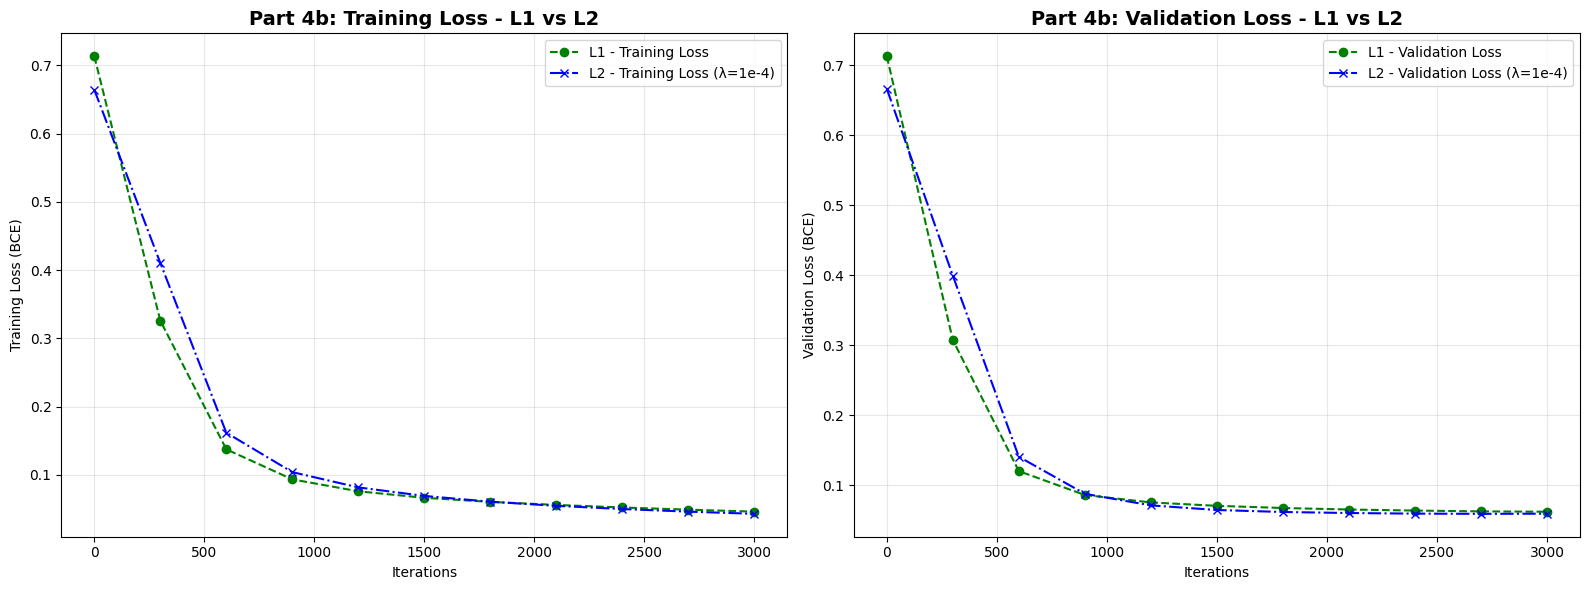

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(iterations_l1, train_losses_l1, label='L1 - Training Loss', color='green', linestyle='--', marker='o')
axes[0].plot(l2_results[LAMBDA_L1]['iterations'], l2_results[1e-4]['train_losses'], label='L2 - Training Loss (λ=1e-4)', color='blue', linestyle='-.', marker='x')

axes[0].set_title('Part 4b: Training Loss - L1 vs L2', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].plot(iterations_l1, val_losses_l1, label='L1 - Validation Loss', color='green', linestyle='--', marker='o')
axes[1].plot(l2_results[LAMBDA_L1]['iterations'], l2_results[LAMBDA_L1]['val_losses'], label='L2 - Validation Loss (λ=1e-4)', color='blue', linestyle='-.', marker='x')

axes[1].set_title('Part 4b: Validation Loss - L1 vs L2', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [51]:

# TODO: Create a summary dataframe with columns:
# Fill rows for: No regularization, L2 (1e-4), L2 (1e-3), L1 (1e-4)
# CODE HERE

def calculate_sparsity(model):
    """Calculate percentage of zero weights in the model."""
    total_params = 0
    zero_params = 0
    with torch.no_grad():
        for param in model.parameters():
            total_params += param.numel()
            zero_params += (param == 0).sum().item()
    return 100 * (zero_params/total_params)

reg_summary = {
    'Regularization': ['None', 'L2 (1e-4)', 'L2 (1e-3)', 'L2 (1e-1)', 'L2 (100)', 'L1 (1e-4)'],
    'Final Val Acc (%)': [
        l2_results[0]['final_accuracy']*100,                                  
        l2_results[1e-4]['final_accuracy']*100,
        l2_results[1e-3]['final_accuracy']*100,
        l2_results[1e-1]['final_accuracy']*100,
        l2_results[100]['final_accuracy']*100,
        final_accuracy_l1*100
    ],
    'Final Train Loss': [
        train_losses_mb[-1],                    
        l2_results[1e-4]['train_losses'][-1],
        l2_results[1e-3]['train_losses'][-1],
        l2_results[1e-1]['train_losses'][-1],
        l2_results[100]['train_losses'][-1],
        train_losses_l1[-1]
    ],
    'Final Val Loss': [
        val_losses_mb[-1],
        l2_results[1e-4]['val_losses'][-1],
        l2_results[1e-3]['val_losses'][-1],
        l2_results[1e-1]['val_losses'][-1],
        l2_results[100]['val_losses'][-1],
        val_losses_l1[-1]
    ],
    'Sparsity (%)': [
        0.0,                                    # no reg
        calculate_sparsity(l2_results[1e-4]['model']),
        calculate_sparsity(l2_results[1e-3]['model']),
        calculate_sparsity(l2_results[1e-1]['model']),
        calculate_sparsity(l2_results[100]['model']),
        calculate_sparsity(model_l1)
    ]
}

# TODO: Fill the summary dictionary
# CODE HERE

reg_df = pd.DataFrame(reg_summary)
display(reg_df)


,Regularization,Final Val Acc (%),Final Train Loss,Final Val Loss,Sparsity (%)
0,None,99.122804,0.044945,0.062216,0.000000
1,L2 (1e-4),97.368419,0.043039,0.059578,0.000000
2,L2 (1e-3),98.245615,0.044222,0.061516,0.000000
3,L2 (1e-1),99.122804,0.159631,0.151720,0.000000
4,L2 (100),62.280703,0.693068,0.693071,99.934938
5,L1 (1e-4),98.245615,0.046262,0.062349,0.000000



#EXPLAIN HERE: Based on your experiments, answer the following questions:


1. What happens when you increase L2 strength from λ=1e-4 to λ=1e-3?

increasing L2 stregnth from 0.0001 to 0.001 increased the final val accuracy showing improved generalization. however, too when delta gets too large, both train loss and val loss skyrocket and accuracy drops. Therefore a small increase in delta reduces overfitting and gives the model better generalization. but too high of a delta destroys the accuracy because the weights are too heavily penalized.
   
2. Which regularization method (L1/L2 or no regulation) achieves better generalization for this breast cancer dataset?

L2 (1e-3) achieved the best generalization for this data compared to any of the L2's and the L1 (1e-4). for this dataset i would recommend using L2 (1e-3)
   